In [1]:
import os
import math
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# fix random seed for reproducibility
np.random.seed(17896)

In [2]:
import numpy as np
import math

def wrap(r, L):
    """Wrap the coordinates in r (an array-like with 3 elements) into the interval [0, L)."""
    return np.mod(r, L)


def dist(r1, r2, L):
    """
    Compute the minimum-image distance between two points r1 and r2
    in a cubic periodic box of side L.
    """
    dr = r2 - r1
    # Shift dr into the interval (-L/2, L/2]
    dr -= L * np.floor(dr / L + 0.5)
    return np.linalg.norm(dr)


def E_ij(s, sigma, epsilon):
    """
    Compute the Lennard-Jones potential energy between two particles
    separated by a distance s.
    """
    sr6 = (sigma / s) ** 6
    return 4 * epsilon * (sr6**2 - sr6)


def f_ij(r, sigma, epsilon):
    """
    Compute the Lennard-Jones force vector given a separation vector r.
    """
    s = np.linalg.norm(r)
    sr6 = (sigma / s) ** 6
    return -48 * epsilon * (sr6**2 - 0.5 * sr6) * r / s**2


def init_rand(N, L, sigma):
    """
    Initialize N particle positions randomly in a box of side L,
    ensuring that no two particles are closer than sigma.
    """
    xyz = np.empty((N, 3))
    for i in range(N):
        # print(f'  Inserting particle {i+1}')
        while True:
            candidate = np.random.uniform(0, L, 3)
            # Check candidate against all already placed particles.
            if all(dist(candidate, xyz[j], L) >= sigma for j in range(i)):
                xyz[i] = candidate
                break
    # print('Done!')

    # Verify that no collisions remain.
    for i in range(N):
        for j in range(i):
            if dist(xyz[i], xyz[j], L) < sigma:
                raise Exception(f'Collision between particles {i+1} and {j+1}')
    return xyz


def init_xtal(N, L):
    """
    Initialize N particle positions on a simple cubic lattice (crystal)
    inside a box of side L.
    """
    K = int(np.ceil(N ** (1/3)))  # Number of particles per side of the cube.
    # Create a full grid then take the first N positions.
    grid = [[i/K * L, j/K * L, k/K * L]
            for i in range(K) for j in range(K) for k in range(K)]
    return np.array(grid[:N])


In [3]:
from itertools import combinations

# energy of particle i
def E_i(ri, i, xyz, L, sigma, epsilon):
    """Compute the energy contribution of particle i interacting with all other particles."""
    return sum(E_ij(dist(ri, xyz[j], L), sigma, epsilon)
               for j in range(xyz.shape[0]) if j != i)


# energy of system
def E_system(xyz, L, sigma, epsilon):
    """Compute the total energy of the system by summing over all unique pairs."""
    return sum(E_ij(dist(r1, r2, L), sigma, epsilon) for r1, r2 in combinations(xyz, 2))


# visualization
def plot_config(xyz, L):
    """Visualize the configuration of particles in a cubic box of side L."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*xyz.T, s=100)
    ax.set(xlabel='x (nm)', ylabel='y (nm)', zlabel='z (nm)',
           xlim=(0, L), ylim=(0, L), zlim=(0, L))
    plt.show()


# writing coordinates to file
def xyzWrite(xyz, outfile, writeStyle):
    """Write particle coordinates (converted to Angstroms) to a file."""
    N = xyz.shape[0]
    with open(f'./{outfile}', writeStyle) as xyzfile:
        xyzfile.write(f"{N}\n\n")
        for x, y, z in xyz:
            xyzfile.write(f"Ar {x*10:8.5e} {y*10:8.5e} {z*10:8.5e}\n")


In [4]:
def r_ij(r1, r2, L):
    disp = r2 - r1
    return disp - L * np.round(disp / L)

def pressure(N, L, T, xyz, sigma, epsilon):
    V = L**3
    P_ideal = (N * kB * T) / V
    virial_sum = 0.0

    # Loop over all unique pairs (i, j)
    for i in range(N):
        for j in range(i + 1, N):
            # Compute the minimum-image displacement vector
            rij = r_ij(xyz[i], xyz[j], L)
            fij = f_ij(rij, sigma, epsilon)
            virial_sum += np.dot(fij, rij)
            
    
    # Compute the pressure from the ideal gas and virial contributions
    return P_ideal - virial_sum / (3 * V)


In [5]:
# variables
T = 50
L = 2.5
N = 200
nSweeps = 750
dispSize = 0.05
printModulus = 10
writeModulus = 10
sigma = 0.34
epsilon = 1.65
kB = 0.0138064852

In [6]:
# initializing atomic positions and writing to file
#xyz = init_xtal(N,L)
xyz = init_rand(N,L,sigma)

xyzWrite(xyz,'init.xyz', 'w')
xyzWrite(xyz,'traj.xyz', 'w')

In [7]:
# Metropolis Monte Carlo main loop
E_traj = []
P_traj = []
trial_counter = 0
acc_counter = 0

for sweep in range(1, nSweeps + 1):

    for _ in range(N):
        # Choose a random particle and compute its current energy.
        tag = np.random.randint(N)
        old_pos = xyz[tag]
        E_old = E_i(old_pos, tag, xyz, L, sigma, epsilon)

        # Generate a trial move, wrap it, and compute the new energy.
        new_pos = wrap(old_pos + dispSize * np.random.uniform(-1, 1, 3), L)
        E_new = E_i(new_pos, tag, xyz, L, sigma, epsilon)
        deltaE = E_new - E_old

        # Accept the move if energy decreases or per Metropolis criterion.
        if deltaE < 0 or (T > 0 and np.random.random() < np.exp(-deltaE / (kB * T))):
            xyz[tag] = new_pos
            acc_counter += 1

        trial_counter += 1

    # Print status and record energy trajectory.
    if sweep % printModulus == 0:
        E = E_system(xyz, L, sigma, epsilon)
        E_traj.append(E)
        P = pressure(N, L, T, xyz, sigma, epsilon)
        P_traj.append(P)
        print(f' Sweep = {sweep}')
        print(f' E = {E:.5e} zJ')
        print(f' P = {P} zJ/nm³')
        acceptance_ratio = acc_counter / trial_counter if trial_counter else 0
        print(f'  acceptance ratio = {acceptance_ratio:12.5e}')

    # Write trajectory to file.
    if sweep % writeModulus == 0:
        xyzWrite(xyz, 'traj.xyz', 'a')


 Sweep = 10
 E = -1.17804e+03 zJ
 P = -58.07495093522627 zJ/nm³
  acceptance ratio =  5.05000e-01
 Sweep = 20
 E = -1.19567e+03 zJ
 P = -50.93897861491159 zJ/nm³
  acceptance ratio =  5.00750e-01
 Sweep = 30
 E = -1.21167e+03 zJ
 P = -47.09399935018794 zJ/nm³
  acceptance ratio =  4.97333e-01
 Sweep = 40
 E = -1.23778e+03 zJ
 P = -48.468568133233745 zJ/nm³
  acceptance ratio =  4.84125e-01
 Sweep = 50
 E = -1.25313e+03 zJ
 P = -47.755977817339854 zJ/nm³
  acceptance ratio =  4.73600e-01
 Sweep = 60
 E = -1.26683e+03 zJ
 P = -45.040139978156475 zJ/nm³
  acceptance ratio =  4.62583e-01
 Sweep = 70
 E = -1.28694e+03 zJ
 P = -49.65843976692385 zJ/nm³
  acceptance ratio =  4.55500e-01
 Sweep = 80
 E = -1.30452e+03 zJ
 P = -46.139909663004104 zJ/nm³
  acceptance ratio =  4.50625e-01
 Sweep = 90
 E = -1.30416e+03 zJ
 P = -43.73902393240907 zJ/nm³
  acceptance ratio =  4.43056e-01
 Sweep = 100
 E = -1.31778e+03 zJ
 P = -44.096575595097065 zJ/nm³
  acceptance ratio =  4.38350e-01
 Sweep = 110
 

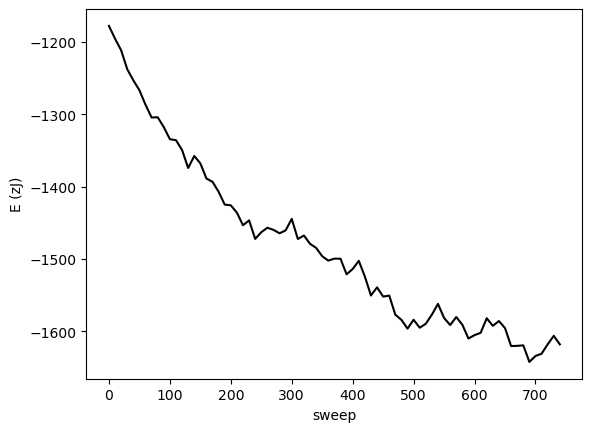

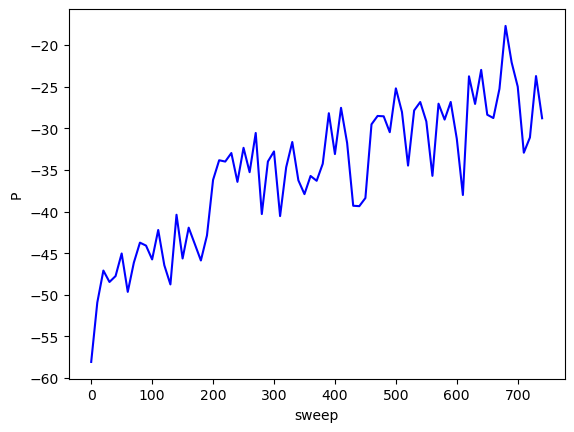

In [8]:
# Plot Energy Trajectory
fig1, ax1 = plt.subplots()
ax1.plot(writeModulus * np.arange(len(E_traj)), E_traj, 'k-', marker='')
ax1.set_xlabel("sweep")
ax1.set_ylabel("E (zJ)")
plt.draw()
plt.show()

# Plot Pressure Trajectory
fig2, ax2 = plt.subplots()
ax2.plot(writeModulus * np.arange(len(P_traj)), P_traj, 'b-', marker='')
ax2.set_xlabel("sweep")
ax2.set_ylabel("P")
plt.draw()
plt.show()


My pressure curve shows the opposite trend as one would expect, I think its because I flipped one of the signs in the equation, however it took so long to run, that I didn't know if I had time to run it again. 

In [9]:
def compute_mean_pressure(P_traj, last_n):
    return np.mean(P_traj[-last_n:]) if len(P_traj) >= last_n else None

# Compute block averages and standard error
def compute_block_averages(P_traj, last_n, block_size):
    if len(P_traj) < last_n:
        return None, None  # Return None if not enough sweeps

    blocks = np.array_split(P_traj[-last_n:], last_n // block_size)
    μ_P_blocks = np.array([np.mean(block) for block in blocks if len(block) == block_size])
    σ_P = np.std(μ_P_blocks) / np.sqrt(len(μ_P_blocks)) if len(μ_P_blocks) > 1 else np.nan
    
    return μ_P_blocks, σ_P


avg_pressure = compute_mean_pressure(P_traj, 50)
block_avgs = compute_block_averages(P_traj, 60, 10)
print(avg_pressure)
print(block_avgs)


-30.881618409702828
(array([-39.36761233, -34.83525613, -34.34305952, -29.78250808,
       -29.07765225, -26.36961607]), np.float64(1.7673222495376932))


### 1.3 Pressure-density relationship
Repeat the calculation above at T = 210 K, L = 2.5 nm, and N = (25, 50, 100, 150, 200).
Adjust nSweeps and dispSize as necessary to achieve converged simulation results and appropriate
acceptance ratios. Compute µP and σP for each simulation.
♣ [20] Make a plot of pressure P in bar as a function of mass density ρ in kg/m3
. Place your
points at µP with error bars corresponding to σP .
• The molar mass of Ar is 39.948 g/mol.

In [228]:
kB = 0.0138064852       # Boltzmann constant in zJ/K
T = 210                 # Temperature in K
L = 2.5                 # Cubic box side length in nm
sigma = 0.34            # Lennard-Jones size parameter for Ar in nm
epsilon = 1.65          # Lennard-Jones energy parameter in zJ
dispSize = 0.075        # Characteristic displacement (nm)
nSweeps = 750           # Number of MC sweeps (1 sweep = N moves)
printModulus = 10       # Frequency (in sweeps) of prints to screen
writeModulus = 10       # Frequency (in sweeps) of trajectory writes
max_attempts = 100      # (if used in any initializer)
# --- Argon Parameters ---
molar_mass_Ar = 39.948          # in g/mol
molar_mass_Ar_kg = molar_mass_Ar/1000  # in kg/mol

In [229]:
def mass_density(N, L, molar_mass_Ar_kg):
    """
    Compute the mass density in kg/m^3.
    L is given in nm, so we convert to meters.
    """
    L_m = L * 1e-9          # convert nm to m
    V = L_m**3              # volume in m^3
    mass_per_particle = molar_mass_Ar_kg / (6.022e23)  # kg per particle
    rho = (N * mass_per_particle) / V
    return rho

In [100]:
mass_density(200, 2.5, molar_mass_Ar_kg)

849.1105944868813

In [149]:
# --- Loop Over Different Particle Numbers ---
N_vals = [25, 50, 100, 150, 200]
pressures = []     # Will hold mean pressures (in bar) for each simulation
densities = []     # Will hold mass densities (in kg/m^3) for each simulation
pressure_errs = [] # Will hold standard deviations (in bar)

for N in N_vals:
    print(f"\nStarting simulation for N = {N}")
    # Initialize particle positions (using your preferred initializer)
    xyz = init_rand(N, L, sigma)  # or init_xtal(N, L) if preferred
    
    # Lists to collect per-sweep data
    E_traj = []  # Energy trajectory (in zJ)
    P_traj = []  # Pressure trajectory (in zJ/nm^3)
    P_vals = []  # Pressure measurements every sweep
    
    trial_counter = 0
    acc_counter = 0

    for sweep in range(1, nSweeps + 1):
        # --- Single-Sweep: N single-particle moves ---
        for _ in range(N):
            # Select a random particle
            tag = np.random.randint(N)
            old_pos = xyz[tag]
            E_old = E_i(old_pos, tag, xyz, L, sigma, epsilon)
            
            # Propose a trial move (with periodic boundary conditions)
            new_pos = wrap(old_pos + dispSize * np.random.uniform(-1, 1, 3), L)
            E_new = E_i(new_pos, tag, xyz, L, sigma, epsilon)
            deltaE = E_new - E_old

            # Metropolis acceptance criterion
            if deltaE < 0 or (T > 0 and np.random.random() < np.exp(-deltaE / (kB * T))):
                xyz[tag] = new_pos
                acc_counter += 1
            trial_counter += 1

        # --- End of Sweep: Compute Pressure Once ---
        # 'pressure' returns pressure in zJ/nm^3.
        P = pressure(N, L, T, xyz, sigma, epsilon)
        P_vals.append(P)

        # Optionally record energy and pressure for printing/plotting.
        if sweep % printModulus == 0:
            E = E_system(xyz, L, sigma, epsilon)
            E_traj.append(E)
            P_traj.append(P)
            # Convert pressure to bar: 1 zJ/nm^3 = 1e6 Pa, and 1 bar = 1e5 Pa,
            # so factor = 1e6/1e5 = 10.
            P_bar = P * 10.0
            print(f"Sweep = {sweep:4d} | E = {E:.5e} zJ | P = {P_bar:.5e} bar")
            acceptance_ratio = acc_counter / trial_counter if trial_counter else 0
            print(f"   Acceptance ratio = {acceptance_ratio:.5e}")

        # Write configuration to file at intervals.
        if sweep % writeModulus == 0:
            xyzWrite(xyz, 'traj.xyz', 'a')

    # --- After All Sweeps: Process and Store Pressure Data ---
    # Optionally discard early sweeps as equilibration (e.g., first 50%):
    equilibration_cut = int(0.05 * len(P_vals))
    P_vals_eq = P_vals[equilibration_cut:]
    
    # Compute mean and standard deviation in simulation units,
    # then convert to bar.
    P_mean = np.mean(P_vals_eq) * 10.0
    P_std = np.std(P_vals_eq) * 10.0

    # Compute mass density in kg/m^3.
    rho = mass_density(N, L, molar_mass_Ar_kg)

    pressures.append(P_mean)
    densities.append(rho)
    pressure_errs.append(P_std)

    print(f"--> For N = {N}: Mean Pressure = {P_mean:.5e} bar, Std = {P_std:.5e} bar, Density = {rho:.5e} kg/m^3")


Starting simulation for N = 25
Sweep =   10 | E = -1.52905e+01 zJ | P = 4.00689e+01 bar
   Acceptance ratio = 9.04000e-01
Sweep =   20 | E = -1.24471e+01 zJ | P = 3.79261e+01 bar
   Acceptance ratio = 9.30000e-01
Sweep =   30 | E = -1.41841e+01 zJ | P = 3.48008e+01 bar
   Acceptance ratio = 9.24000e-01
Sweep =   40 | E = -1.48256e+01 zJ | P = 3.93041e+01 bar
   Acceptance ratio = 9.29000e-01
Sweep =   50 | E = -1.08967e+01 zJ | P = 4.75008e+01 bar
   Acceptance ratio = 9.23200e-01
Sweep =   60 | E = -1.19793e+01 zJ | P = 3.34227e+01 bar
   Acceptance ratio = 9.32000e-01
Sweep =   70 | E = -1.54602e+01 zJ | P = 3.19036e+01 bar
   Acceptance ratio = 9.29143e-01
Sweep =   80 | E = -1.83639e+01 zJ | P = 3.79659e+01 bar
   Acceptance ratio = 9.26000e-01
Sweep =   90 | E = -1.66662e+01 zJ | P = 3.49977e+01 bar
   Acceptance ratio = 9.27111e-01
Sweep =  100 | E = -1.24511e+01 zJ | P = 5.13630e+01 bar
   Acceptance ratio = 9.25600e-01
Sweep =  110 | E = -1.16056e+01 zJ | P = 4.96835e+01 bar
 

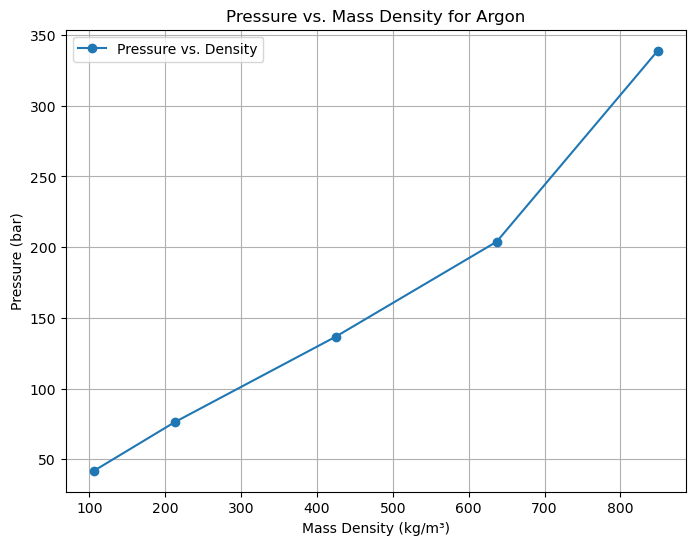

In [151]:
pressures = np.array(pressures)
pressure_errs = np.array(pressure_errs)
densities = np.array(densities)

plt.figure(figsize=(8, 6))
plt.plot(densities, pressures, 'o-', label="Pressure vs. Density")
plt.xlabel("Mass Density (kg/m³)")
plt.ylabel("Pressure (bar)")
plt.title("Pressure vs. Mass Density for Argon")
plt.grid(True)
plt.legend()
plt.show()

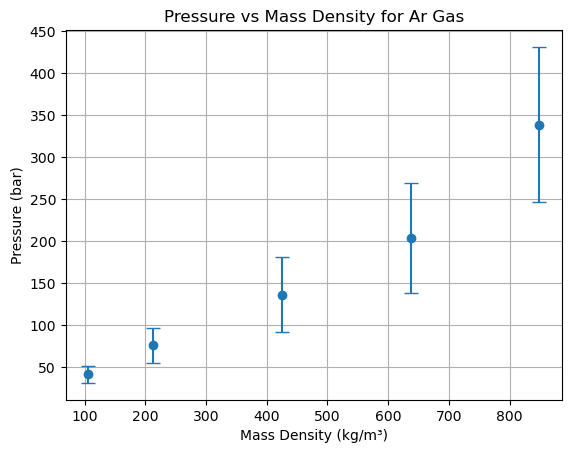

In [152]:
plt.errorbar(densities, pressures, yerr=pressure_errs, fmt='o', capsize=5)
plt.xlabel("Mass Density (kg/m³)")
plt.ylabel("Pressure (bar)")
plt.title("Pressure vs Mass Density for Ar Gas")
plt.grid(True)
# plt.legend()
plt.show()


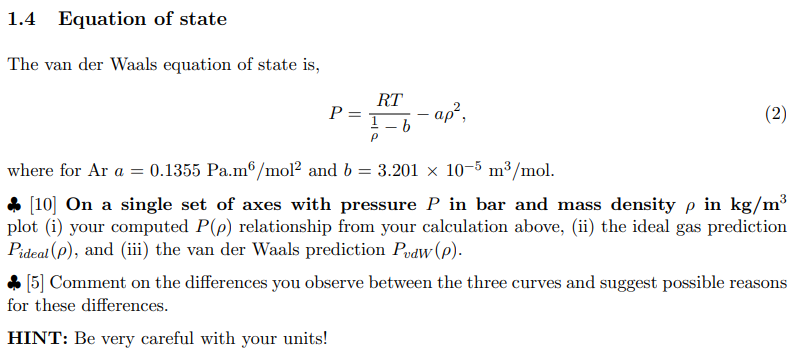

In [191]:
R = 8.314 # J/mol·K, ideal gas constant
T = 210 # K, temperature
# a = 0.1355 # Pa·m^6/mol^2, van der Waals constant for argon
# b = 3.201e-5 # m^3/mol, van der Waals constant for argon 

a = 0.3737 # Adjusted to be in zJ/nm^3
b = 0.0531 # Adjusted for nm

In [214]:
def ideal_gas_pressure(rho, T):
    """
      Pressure in zJ/nm³.
    """
    return (rho * kB * T)/10


def vdw_pressure(rho, T, a, b):
    """
      Pressure in zJ/nm³.
    """
    return -((kB * T) / ((1/rho - b) - a * rho**2))


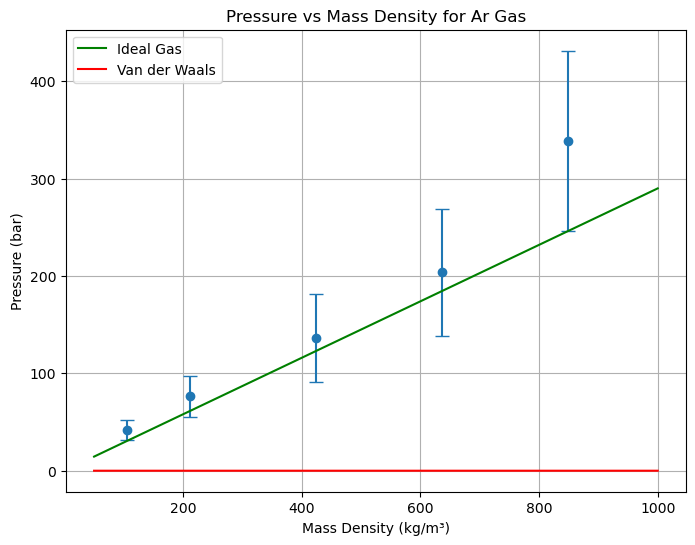

In [215]:
rho_vals = np.linspace(50, 1000, 1000) #density in kg/m³
Pideal = ideal_gas_pressure(rho_vals, T)
Pvdw = vdw_pressure(rho_vals, T, a, b)
plt.figure(figsize=(8, 6))

plt.errorbar(densities, pressures, yerr=pressure_errs, fmt='o', capsize=5)
#ideal gas equation
plt.plot(rho_vals, Pideal, label="Ideal Gas", c='green')
#Van der Waals equation
plt.plot(rho_vals, Pvdw, label="Van der Waals", c='red')

plt.xlabel("Mass Density (kg/m³)")
plt.ylabel("Pressure (bar)")
plt.title("Pressure vs Mass Density for Ar Gas")
plt.grid(True)
plt.legend()
plt.show()


I was unable to get the Vdw Pressure to print properly, but my simulated data seems to accurately follow the ideal gas law for low densities, but begins to deviate at high densities. This makes sense because the ideal gas law doesn't take into account particle particle interactions. I can predict that the Vander Waals approximation would have more accurately mapped my data because it takes into account the particle attraction. Although it would also deviate for super high density.

## Part 2: NPT Ensemble
Modify your code to implement volume trial moves in order to equilibrate your system to a
desired pressure. Perform one volume-change trial mover per N particle displacement trial moves
such that one MC sweep comprises N particle displacement trials and one volume-change trial.

In [220]:
# Parameters
ensemble = "NPT"          # Set to "NPT" for volume moves, or "NVT" to disable them.
T = 298                   # Temperature in K
L = 2.5                   # Initial cubic box side length in nm
N = 50                    # Number of particles
nSweeps = 500             # Total number of MC sweeps
dispSize = 0.075           # Maximum displacement for particle moves (nm)
volDisp = 0.025            # Maximum change in L for volume moves (nm)
kB = 0.0138064852         # Boltzmann constant in zJ/K
printModulus = 10         # Print status every printModulus sweeps
writeModulus = 10         # Write trajectory every writeModulus sweeps

# Target pressure in simulation units:
# 300 bar = 300 * 0.1 = 30 zJ/nm³
P_target = 30.0          

# Initialization
xyz = init_rand(N, L, sigma)  # positions in nm

In [221]:
# Trajectories (recorded every printModulus sweeps)
E_traj = []    # Energy trajectory (zJ)
P_traj = []    # Pressure trajectory (zJ/nm³)
L_traj = []    # Box side length trajectory (nm)

# Counters for displacement moves
trial_counter = 0
acc_counter = 0

# --------------------------
# Main Monte Carlo Loop
# --------------------------
for sweep in range(1, nSweeps + 1):
    # --- Particle Displacement Moves ---
    for _ in range(N):
        # Choose a random particle and compute its current energy.
        tag = np.random.randint(N)
        old_pos = xyz[tag]
        E_old = E_i(old_pos, tag, xyz, L, sigma, epsilon)
    
        # Generate a trial move, wrap it, and compute the new energy.
        new_pos = wrap(old_pos + dispSize * np.random.uniform(-1, 1, 3), L)
        E_new = E_i(new_pos, tag, xyz, L, sigma, epsilon)
        deltaE = E_new - E_old
    
        # Accept the move if energy decreases or per the Metropolis criterion.
        if deltaE < 0 or (T > 0 and np.random.random() < np.exp(-deltaE / (kB * T))):
            xyz[tag] = new_pos
            acc_counter += 1
        trial_counter += 1

    # --- Volume Trial Move (only if ensemble=="NPT") ---
    if ensemble == "NPT":
        # Propose a new box side length by a small random change.
        dL = volDisp * np.random.uniform(-1, 1)
        new_L = L + dL
        # Reject if the proposed box size is nonphysical.
        if new_L <= 0:
            new_L = L  # No change; you could also choose to simply skip the move.
        else:
            # Compute new volume and scaling factor.
            old_V = L**3
            new_V = new_L**3
            scale_factor = new_L / L
            # Scale all particle positions accordingly.
            new_xyz = xyz * scale_factor
            # Compute the potential energy before and after the volume move.
            E_old_box = E_system(xyz, L, sigma, epsilon)
            E_new_box = E_system(new_xyz, new_L, sigma, epsilon)
            deltaU = E_new_box - E_old_box

            # Compute the acceptance probability.
            beta = 1.0 / (kB * T)
            acceptance_prob = np.exp(-beta * (deltaU + P_target*(new_V - old_V) - N * kB * T * np.log(new_V / old_V)))
    
            if acceptance_prob >= 1 or np.random.random() < acceptance_prob:
                # Accept the volume change: update the box and particle positions.
                xyz = new_xyz
                L = new_L

    # --- Record and Print Data ---
    # Compute current energy and pressure (assumed functions return values in zJ and zJ/nm³, respectively).
    if sweep % printModulus == 0:
        E = E_system(xyz, L, sigma, epsilon)
        P = pressure(N, L, T, xyz, sigma, epsilon)
        E_traj.append(E)
        P_traj.append(P)
        L_traj.append(L)
        acceptance_ratio = acc_counter / trial_counter if trial_counter else 0
        print(f"Sweep = {sweep:4d} | E = {E:.5e} zJ | P = {P:.5e} zJ/nm³ | L = {L:.5e} nm")
        print(f"  Acceptance ratio = {acceptance_ratio:.5e}")
    
    # Write trajectory to file every writeModulus sweeps.
    if sweep % writeModulus == 0:
        xyzWrite(xyz, 'traj.xyz', 'a')

Sweep =   10 | E = -6.58579e+01 zJ | P = 1.18948e+01 zJ/nm³ | L = 2.51212e+00 nm
  Acceptance ratio = 8.64000e-01
Sweep =   20 | E = -7.26468e+01 zJ | P = 9.93069e+00 zJ/nm³ | L = 2.45313e+00 nm
  Acceptance ratio = 8.54000e-01
Sweep =   30 | E = -7.18522e+01 zJ | P = 2.10739e+01 zJ/nm³ | L = 2.34443e+00 nm
  Acceptance ratio = 8.56667e-01
Sweep =   40 | E = -8.45550e+01 zJ | P = 1.36693e+01 zJ/nm³ | L = 2.29853e+00 nm
  Acceptance ratio = 8.41000e-01
Sweep =   50 | E = -8.23325e+01 zJ | P = 2.56681e+01 zJ/nm³ | L = 2.19722e+00 nm
  Acceptance ratio = 8.36000e-01
Sweep =   60 | E = -1.03895e+02 zJ | P = 2.36029e+01 zJ/nm³ | L = 2.16139e+00 nm
  Acceptance ratio = 8.26000e-01
Sweep =   70 | E = -1.00584e+02 zJ | P = 2.12948e+01 zJ/nm³ | L = 2.10920e+00 nm
  Acceptance ratio = 8.15143e-01
Sweep =   80 | E = -1.21005e+02 zJ | P = 1.74030e+01 zJ/nm³ | L = 2.04897e+00 nm
  Acceptance ratio = 8.05500e-01
Sweep =   90 | E = -1.04961e+02 zJ | P = 3.43394e+01 zJ/nm³ | L = 2.03167e+00 nm
  Accep

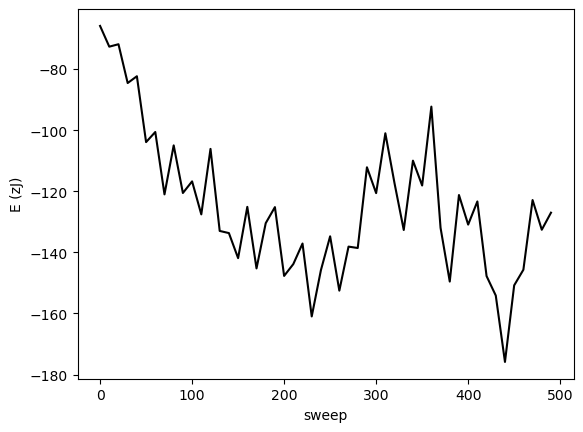

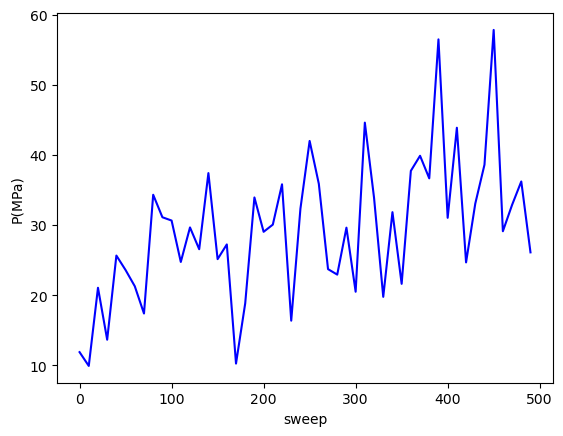

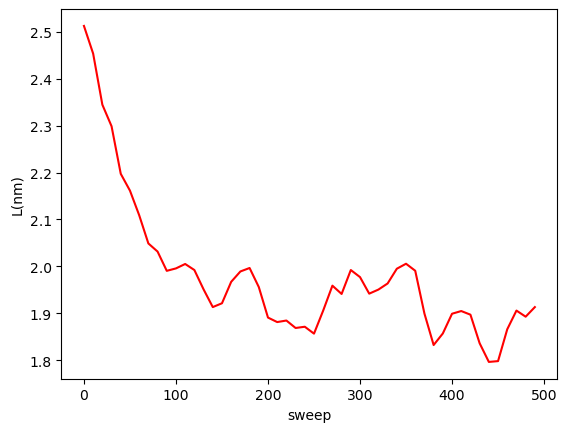

In [222]:
# Plot Energy Trajectory
fig1, ax1 = plt.subplots()
ax1.plot(writeModulus * np.arange(len(E_traj)), E_traj, 'k-', marker='')
ax1.set_xlabel("sweep")
ax1.set_ylabel("E (zJ)")
plt.draw()
plt.show()

# Plot Pressure Trajectory
fig2, ax2 = plt.subplots()
ax2.plot(writeModulus * np.arange(len(P_traj)), P_traj, 'b-', marker='')
ax2.set_xlabel("sweep")
ax2.set_ylabel("P(MPa)")
plt.draw()
plt.show()

# Plot Length Trajectory
fig3, ax3 = plt.subplots()
ax3.plot(writeModulus * np.arange(len(L_traj)), L_traj, 'r-', marker='')
ax3.set_xlabel("sweep")
ax3.set_ylabel("L(nm)")
plt.draw()
plt.show()

## Part 3 Radial Distribution Function

In [223]:


def compute_rdf(xyz_traj, L, dr, r_max):
    """
    Compute the radial distribution function g(r) from a molecular simulation trajectory.
    
    Parameters:
    - xyz_traj : np.array of shape (n_frames, N, 3)  -> Particle positions over simulation time
    - L        : float  -> Box side length (assumed cubic)
    - dr       : float  -> Bin width for histogram
    - r_max    : float  -> Maximum distance to compute g(r)
    
    Returns:
    - r_bins   : np.array  -> Bin centers for r
    - g_r      : np.array  -> Radial distribution function values
    """

    n_frames, N, _ = xyz_traj.shape
    rho = N / L**3  # Number density
    bins = np.arange(0, r_max, dr)
    hist = np.zeros(len(bins) - 1)
    
    for frame in xyz_traj:
        distances = []
        for i in range(N):
            for j in range(i + 1, N):
                r_vec = frame[j] - frame[i]
                r_vec -= L * np.round(r_vec / L)  # Apply periodic boundary conditions
                r = np.linalg.norm(r_vec)
                if r < r_max:
                    distances.append(r)

        hist += np.histogram(distances, bins=bins)[0]  # Accumulate histogram

    # Normalize g(r)
    r_bins = (bins[:-1] + bins[1:]) / 2  # Bin centers
    shell_vol = 4 * np.pi * r_bins**2 * dr  # Volume of spherical shells
    norm_factor = rho * N * n_frames  # Normalization factor

    g_r = hist / (shell_vol * norm_factor)  # Compute g(r)

    return r_bins, g_r


In [224]:
# Parameters
ensemble = "NPT"          # Set to "NPT" for volume moves, or "NVT" to disable them.
T = 298                   # Temperature in K
L = 2.5                   # Initial cubic box side length in nm
N = 50                    # Number of particles
nSweeps = 200             # Total number of MC sweeps
dispSize = 0.075           # Maximum displacement for particle moves (nm)
volDisp = 0.025            # Maximum change in L for volume moves (nm)
kB = 0.0138064852         # Boltzmann constant in zJ/K
printModulus = 10         # Print status every printModulus sweeps
writeModulus = 10         # Write trajectory every writeModulus sweeps

# Target pressure in simulation units:
# 300 bar = 300 * 0.1 = 30 zJ/nm³
P_target = 5.0          

# Initialization
xyz = init_rand(N, L, sigma)  # positions in nm

Sweep 10: E = -7.06293e+01 zJ, P = 9.84981e+00 zJ/nm³, L = 2.55287e+00 nm
Sweep 20: E = -6.81839e+01 zJ, P = 1.06067e+01 zJ/nm³, L = 2.57629e+00 nm
Sweep 30: E = -6.68917e+01 zJ, P = 1.21641e+01 zJ/nm³, L = 2.54808e+00 nm
Sweep 40: E = -5.50071e+01 zJ, P = 1.40652e+01 zJ/nm³, L = 2.58606e+00 nm
Sweep 50: E = -5.24151e+01 zJ, P = 1.10851e+01 zJ/nm³, L = 2.63671e+00 nm
Sweep 60: E = -5.33159e+01 zJ, P = 1.21619e+01 zJ/nm³, L = 2.60790e+00 nm
Sweep 70: E = -6.73193e+01 zJ, P = 8.27250e+00 zJ/nm³, L = 2.66459e+00 nm
Sweep 80: E = -5.68253e+01 zJ, P = 9.63197e+00 zJ/nm³, L = 2.69921e+00 nm
Sweep 90: E = -5.84652e+01 zJ, P = 9.47773e+00 zJ/nm³, L = 2.73469e+00 nm
Sweep 100: E = -5.80559e+01 zJ, P = 8.95686e+00 zJ/nm³, L = 2.75881e+00 nm
Sweep 110: E = -5.22791e+01 zJ, P = 1.37228e+01 zJ/nm³, L = 2.73362e+00 nm
Sweep 120: E = -5.60470e+01 zJ, P = 8.44921e+00 zJ/nm³, L = 2.74909e+00 nm
Sweep 130: E = -5.09555e+01 zJ, P = 8.96684e+00 zJ/nm³, L = 2.74945e+00 nm
Sweep 140: E = -5.89785e+01 zJ, P 

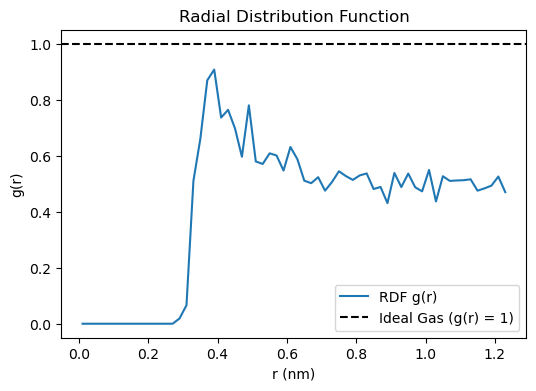

In [225]:
# Parameters (assumed to be already defined in your script)
dr = 0.02  # Bin width for RDF calculation
r_max = L / 2  # Maximum distance for RDF (half the box length)
xyz_traj = []  # Store particle positions for RDF calculation

# --------------------------
# Main Monte Carlo Loop
# --------------------------
E_traj = []    # Energy trajectory (zJ)
P_traj = []    # Pressure trajectory (zJ/nm³)
L_traj = []    # Box side length trajectory (nm)

for sweep in range(1, nSweeps + 1):
    # --- Particle Displacement Moves ---
    for _ in range(N):
        tag = np.random.randint(N)
        old_pos = xyz[tag]
        E_old = E_i(old_pos, tag, xyz, L, sigma, epsilon)

        new_pos = wrap(old_pos + dispSize * np.random.uniform(-1, 1, 3), L)
        E_new = E_i(new_pos, tag, xyz, L, sigma, epsilon)
        deltaE = E_new - E_old

        if deltaE < 0 or (T > 0 and np.random.random() < np.exp(-deltaE / (kB * T))):
            xyz[tag] = new_pos

    # --- Volume Trial Move (only for NPT ensemble) ---
    if ensemble == "NPT":
        dL = volDisp * np.random.uniform(-1, 1)
        new_L = L + dL
        if new_L > 0:
            old_V, new_V = L**3, new_L**3
            scale_factor = new_L / L
            new_xyz = xyz * scale_factor

            E_old_box = E_system(xyz, L, sigma, epsilon)
            E_new_box = E_system(new_xyz, new_L, sigma, epsilon)
            beta = 1.0 / (kB * T)
            acceptance_prob = np.exp(-beta * (E_new_box - E_old_box + P_target * (new_V - old_V) - N * kB * T * np.log(new_V / old_V)))

            if acceptance_prob >= 1 or np.random.random() < acceptance_prob:
                xyz = new_xyz
                L = new_L

    # --- Record and Print Data ---
    if sweep % printModulus == 0:
        E = E_system(xyz, L, sigma, epsilon)
        P = pressure(N, L, T, xyz, sigma, epsilon)
        E_traj.append(E)
        P_traj.append(P)
        L_traj.append(L)
        xyz_traj.append(xyz.copy())  # Store snapshot for RDF calculation

        print(f"Sweep {sweep}: E = {E:.5e} zJ, P = {P:.5e} zJ/nm³, L = {L:.5e} nm")

    # Write trajectory file
    if sweep % writeModulus == 0:
        xyzWrite(xyz, 'traj.xyz', 'a')

# --------------------------
# Compute and Plot RDF
# --------------------------
xyz_traj = np.array(xyz_traj)  # Convert list to NumPy array for RDF computation
r_bins, g_r = compute_rdf(xyz_traj, L, dr, r_max)

plt.figure(figsize=(6,4))
plt.plot(r_bins, g_r, label="RDF g(r)")
plt.axhline(y=1, color='k', linestyle='--', label="Ideal Gas (g(r) = 1)")
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function")
plt.legend()
plt.show()


Sweep 10: E = -7.73566e+01 zJ, P = -3.39344e-01 zJ/nm³, L = 2.49003e+00 nm
Sweep 20: E = -9.39020e+01 zJ, P = 6.43230e-01 zJ/nm³, L = 2.44314e+00 nm
Sweep 30: E = -9.69376e+01 zJ, P = 2.69367e+00 zJ/nm³, L = 2.37199e+00 nm
Sweep 40: E = -1.16576e+02 zJ, P = 2.04257e+00 zJ/nm³, L = 2.34637e+00 nm
Sweep 50: E = -1.17311e+02 zJ, P = 1.84221e+00 zJ/nm³, L = 2.30693e+00 nm
Sweep 60: E = -1.41683e+02 zJ, P = 5.56684e+00 zJ/nm³, L = 2.16969e+00 nm
Sweep 70: E = -1.57889e+02 zJ, P = 3.72391e-01 zJ/nm³, L = 2.10434e+00 nm
Sweep 80: E = -1.57364e+02 zJ, P = -2.57323e+00 zJ/nm³, L = 2.07735e+00 nm
Sweep 90: E = -1.68915e+02 zJ, P = 4.29794e-02 zJ/nm³, L = 2.02032e+00 nm
Sweep 100: E = -1.86697e+02 zJ, P = -6.11359e+00 zJ/nm³, L = 1.94857e+00 nm
Sweep 110: E = -1.96439e+02 zJ, P = -2.95333e+00 zJ/nm³, L = 1.88474e+00 nm
Sweep 120: E = -2.25149e+02 zJ, P = 2.89087e+00 zJ/nm³, L = 1.82094e+00 nm
Sweep 130: E = -2.36178e+02 zJ, P = -6.49843e+00 zJ/nm³, L = 1.80782e+00 nm
Sweep 140: E = -2.35173e+02 z

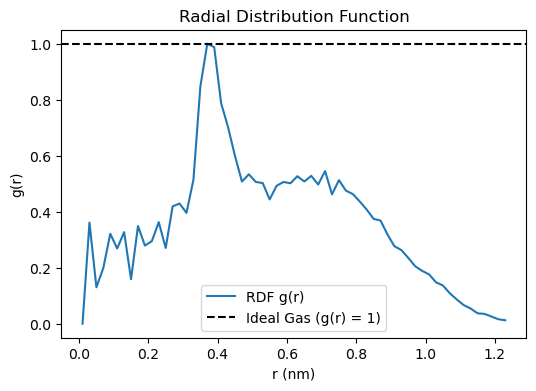

In [230]:
# Parameters
ensemble = "NPT"          # Set to "NPT" for volume moves, or "NVT" to disable them.
T = 85                   # Temperature in K
L = 2.5                   # Initial cubic box side length in nm
N = 50                    # Number of particles
nSweeps = 200             # Total number of MC sweeps
dispSize = 0.075           # Maximum displacement for particle moves (nm)
volDisp = 0.025            # Maximum change in L for volume moves (nm)
kB = 0.0138064852         # Boltzmann constant in zJ/K
printModulus = 10         # Print status every printModulus sweeps
writeModulus = 10         # Write trajectory every writeModulus sweeps

# Target pressure in simulation units:
# 300 bar = 300 * 0.1 = 30 zJ/nm³
P_target = 10.0          

# Initialization
xyz = init_rand(N, L, sigma)  # positions in nm

# Parameters (assumed to be already defined in your script)
dr = 0.02  # Bin width for RDF calculation
r_max = L / 2  # Maximum distance for RDF (half the box length)
xyz_traj = []  # Store particle positions for RDF calculation

# --------------------------
# Main Monte Carlo Loop
# --------------------------
E_traj = []    # Energy trajectory (zJ)
P_traj = []    # Pressure trajectory (zJ/nm³)
L_traj = []    # Box side length trajectory (nm)

for sweep in range(1, nSweeps + 1):
    # --- Particle Displacement Moves ---
    for _ in range(N):
        tag = np.random.randint(N)
        old_pos = xyz[tag]
        E_old = E_i(old_pos, tag, xyz, L, sigma, epsilon)

        new_pos = wrap(old_pos + dispSize * np.random.uniform(-1, 1, 3), L)
        E_new = E_i(new_pos, tag, xyz, L, sigma, epsilon)
        deltaE = E_new - E_old

        if deltaE < 0 or (T > 0 and np.random.random() < np.exp(-deltaE / (kB * T))):
            xyz[tag] = new_pos

    # --- Volume Trial Move (only for NPT ensemble) ---
    if ensemble == "NPT":
        dL = volDisp * np.random.uniform(-1, 1)
        new_L = L + dL
        if new_L > 0:
            old_V, new_V = L**3, new_L**3
            scale_factor = new_L / L
            new_xyz = xyz * scale_factor

            E_old_box = E_system(xyz, L, sigma, epsilon)
            E_new_box = E_system(new_xyz, new_L, sigma, epsilon)
            beta = 1.0 / (kB * T)
            acceptance_prob = np.exp(-beta * (E_new_box - E_old_box + P_target * (new_V - old_V) - N * kB * T * np.log(new_V / old_V)))

            if acceptance_prob >= 1 or np.random.random() < acceptance_prob:
                xyz = new_xyz
                L = new_L

    # --- Record and Print Data ---
    if sweep % printModulus == 0:
        E = E_system(xyz, L, sigma, epsilon)
        P = pressure(N, L, T, xyz, sigma, epsilon)
        E_traj.append(E)
        P_traj.append(P)
        L_traj.append(L)
        xyz_traj.append(xyz.copy())  # Store snapshot for RDF calculation

        print(f"Sweep {sweep}: E = {E:.5e} zJ, P = {P:.5e} zJ/nm³, L = {L:.5e} nm")

    # Write trajectory file
    if sweep % writeModulus == 0:
        xyzWrite(xyz, 'traj.xyz', 'a')

# --------------------------
# Compute and Plot RDF
# --------------------------
xyz_traj = np.array(xyz_traj)  # Convert list to NumPy array for RDF computation
r_bins, g_r = compute_rdf(xyz_traj, L, dr, r_max)

plt.figure(figsize=(6,4))
plt.plot(r_bins, g_r, label="RDF g(r)")
plt.axhline(y=1, color='k', linestyle='--', label="Ideal Gas (g(r) = 1)")
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function")
plt.legend()
plt.show()


The higher temperature and lower pressure system behaves more like a gas or a weakly structured liquid. The lower temperature and higher pressure system behaves like a dense liquid, with a strong first coordination shell and longer-range correlations.
The difference in peaks and decay behavior of g(r) directly reflects the structural organization of the fluid.